In [1]:
import math
from tensorboardX import SummaryWriter
sess = None

In [2]:
import tensorflow as tf
import collections
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.8)
tf.reset_default_graph()
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
from gym import envs
#print(envs.registry.all())

4
done
(84, 84, 4)


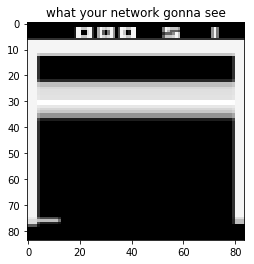

In [4]:
from wrappers import make_atari_deepmind
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#env_name = "PongNoFrameskip-v4"
env_name = "BreakoutNoFrameskip-v4"
env = make_atari_deepmind(env_name)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
print(n_actions)
obs = env.reset()
obs, r, done, _ = env.step(2)
#print(obs.shape)
#print(is_done)
done = False
for _ in range(2000):
    obs, _, done, _ = env.step(3)
    obs = np.array(obs)
    if done:
        print('done')
        break
plt.title("what your network gonna see")
print (obs.shape)
plt.imshow(obs[:,:,0],interpolation='none',cmap='gray');

In [5]:

from dqnagent import DQNAgent

import networks


#agent.epsilon = 0.5

breakout_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 8,
    'BATCH_SIZE' : 32 * 2,
    'EPSILON' : 0,
    'MIN_EPSILON' : 0,
    'EPSILON_DECAY_FRAMES' : 100000,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'NAME' : 'ENDDDQN2',
    'IS_DOUBLE' : False,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 420,
    'NUM_STEPS_FILL_BUFFER' : 10000,
    'REPLAY_BUFFER_TYPE' : 'notmal',
    'REPLAY_BUFFER_SIZE' : 100000,
    'PRIORITY_BETA' : 0.4,
    'PRIORITY_ALPHA' : 0.6,
    'BETA_DECAY_FRAMES' : 1e5,
    'MAX_BETA' : 1,
    'LIVES_REWARD' : 5,
    'NETWORK' : networks.AtariNoisyDuelingDQN()
    }


pong_dddqn_config = {
    'GAMMA' : 0.99,
    'LEARNING_RATE' : 1e-4,
    'STEPS_PER_EPOCH' : 8,
    'BATCH_SIZE' : 32 * 4,
    'EPSILON' : 1.0,
    'MIN_EPSILON' : 0.02,
    'EPSILON_DECAY_FRAMES' : 100000,
    'NUM_EPOCHS_TO_COPY' : 1000,
    'NAME' : 'PongDDDQN',
    'IS_DOUBLE' : True,
    'DUELING_TYPE' : 'AVERAGE',
    'SCORE_TO_WIN' : 20,
    'NUM_STEPS_FILL_BUFFER' : 10000,
    'REPLAY_BUFFER_TYPE' : 'prioritized',
    'REPLAY_BUFFER_SIZE' : 100000,
    'PRIORITY_BETA' : 0.4,
    'PRIORITY_ALPHA' : 0.6,
    'BETA_DECAY_FRAMES' : 1e5,
    'MAX_BETA' : 1,
    'NETWORK' : networks.AtariDuelingDQN(),
    'LIVES_REWARD' : 1
    }
agent = DQNAgent(env, sess, env_name, config = breakout_dddqn_config)
#agent.restore('nn/NDDDQNBreakoutNoFrameskip-v4')
#agent.epsilon = 0.02

In [ ]:
env.reset()
agent.train()

In [ ]:
#agent.epsilon = 0.2
#agent.train()
import wrappers

In [ ]:
#env_monitor.close()
print(env.unwrapped.get_action_meanings())
def evaluate(env,t_max=10000):
    rewards = []
    env._max_episode_steps = 9999
    print('reset')
    #env = env.old_env
    s = env.reset()
    reward = 0
    for it in range(t_max):
        #e.render()
        qvalues = agent.get_qvalues([s])
        action = np.argmax(qvalues)
        s, r, done, _ = env.step(action)
        reward += r
        
            
        if done:
            
            break       
        
    return reward

import gym.wrappers
env_monitor = wrappers.make_atari_deepmind(env_name)
env_monitor = wrappers.ReallyDoneWrapper(env_monitor)
env_monitor = gym.wrappers.Monitor(env_monitor,directory='video_dddqn01',force=True, write_upon_reset=True)
sessions = [print('reward:', evaluate(env_monitor)) for _ in range(1)]
env_monitor.close()

In [ ]:
#tf.reset_default_graph()
#agent = DQNAgent(env, sess, ExperienceBuffer(EXP_BUFFER_CAPACITY), env_name, config = dqn_config)

In [ ]:
#env.reset()
#agent.train()

In [8]:
import collections
import numpy as np
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=True)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

from experience import ReplayBuffer
import wrappers
import gym
import time
env = None
def play_step(buf, env, curr_state):
    action = env.action_space.sample()
    
    # do step in the environment
    qvalues = agent.get_qvalues([curr_state])
    action = np.argmax(qvalues)
    new_state, reward, is_done, _ = env.step(action)
    curr_state = new_state
    buf.add(curr_state, action, reward, is_done, new_state)
    #obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch  = buf.sample(32)
    if is_done:
        curr_state = env.reset() 
    return curr_state

def do_test():
    buf = None
    buf = ReplayBuffer(100000)
    frame = 0
    dt = 0
    env = wrappers.make_atari_deepmind("BreakoutNoFrameskip-v4")
    curr_state = env.reset() 
    while True:
        frame += 1
        t1 = time.time()
        curr_state = play_step(buf, env, curr_state)
        t2 = time.time()
        dt += t2 - t1
        
        if frame % 1000 == 0 and frame != 0:
            print(dt)
            print(frame)
            dt = 0
            
        

In [ ]:
do_test()

2.678833484649658
1000
2.6240460872650146
2000
2.623035430908203
3000
2.5710959434509277
4000
2.8523740768432617
5000
3.1256399154663086
6000
3.1525681018829346
7000
3.0547659397125244
8000
2.7181780338287354
9000
2.7429516315460205
10000
2.7844579219818115
11000
3.0987093448638916
12000
2.74767804145813
13000
3.027876377105713
14000
2.9614152908325195
15000
3.0149638652801514
16000
2.676785469055176
17000
2.6928012371063232
18000
2.9859836101531982
19000
2.7017691135406494
20000
2.664844036102295
21000
2.7127463817596436
22000
2.6319284439086914
23000
2.6578919887542725
24000
2.6778407096862793
25000
2.6817448139190674
26000
3.0817575454711914
27000
3.369985818862915
28000
2.767598867416382
29000
2.8074896335601807
30000
2.7465920448303223
31000
2.6778616905212402
32000
2.674821138381958
33000
2.6608543395996094
34000
2.8924925327301025
35000
2.890801429748535
36000
2.9686224460601807
37000
2.8812944889068604
38000
2.919156551361084
39000
2.870917558670044
40000
2.834080934524536
4100